In [1]:
import os
import re
import logging
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment


In [2]:
# load data
df = pd.read_csv('data/30s_segments.csv', sep=",")
df = df[:1000]
len(df)

1000

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

2024-12-03 00:23:28.284149: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 00:23:28.469085: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 00:23:28.638594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733160208.786452  110914 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733160208.826831  110914 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 00:23:29.196098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [ ]:
def extract_features(yamnet_model, file_path):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=16000)
    
    # Run the YAMNet model to get the embeddings
    scores, embeddings, spectrogram = yamnet_model(audio)
    
    return embeddings.numpy()

In [5]:
df['features'] = df['30s_path'].apply(lambda x: extract_features(yamnet_model, x))

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Extract features and labels
X = np.array(df['features'].tolist())
y = label_encoder.fit_transform(df['title'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"{len(np.unique(y_train))}")

X_train shape: (800, 62, 1024)
X_test shape: (200, 62, 1024)
y_train shape: (800,)
y_test shape: (200,)
14


# other architecture
- Recurrent Neural Network (RNN)

```py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten

model = Sequential()
model.add(LSTM(128, input_shape=(62, 1024), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Flatten())
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

model.summary()

```

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten

# model = Sequential([
#     tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
# ])

model = Sequential()
model.add(LSTM(128, input_shape=(62, 1024), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Flatten())
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

model.summary()

/home/reiaslite/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 62, 128)        │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 62, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 62, 64)         │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │        55,566 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785,742 (3.00 MB)

 Trainable params: 785,742 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#callbacks
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.1692 - loss: 2.5045 - val_accuracy: 0.4500 - val_loss: 1.7205
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.5447 - loss: 1.4240 - val_accuracy: 0.6700 - val_loss: 1.0558
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.7279 - loss: 0.8118 - val_accuracy: 0.7950 - val_loss: 0.8330
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.8531 - loss: 0.4574 - val_accuracy: 0.8150 - val_loss: 0.7608
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.8596 - loss: 0.3985 - val_accuracy: 0.7950 - val_loss: 0.6572
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9044 - loss: 0.2634 - val_accuracy: 0.8000 - val_loss: 0.8000
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9506 - loss: 0.1437 - val_accuracy: 0.7900 - val_loss: 0.6657
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9428 - loss: 0.2009 - val_accuracy: 0.

In [10]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8735 - loss: 0.5946
Test Loss: 0.6614809632301331
Test Accuracy: 0.8799999952316284


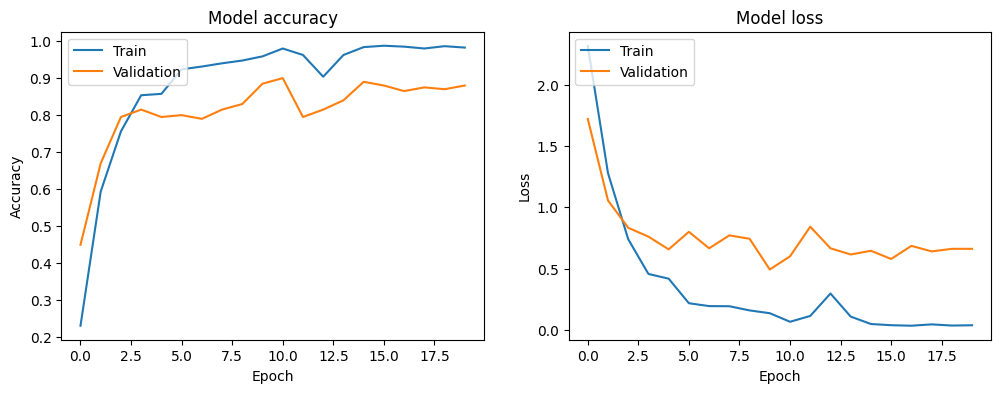

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [13]:
wav_test = 'datasets/test/segment_727_1.wav'

# Extract features from the test audio file
test_features = extract_features(yamnet_model, wav_test)

# Reshape the features to match the input shape of the model
test_features = np.expand_dims(test_features, axis=0)

# Make a prediction using the trained model
prediction = model.predict(test_features)

# Decode the prediction to get the class label
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])

# prediction percentage
prediction_percentage = np.max(prediction) * 100

print(f"Predicted label: {predicted_label[0]}")
print(f"Prediction percentage: {prediction_percentage:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted label: Ondel-Ondel
Prediction percentage: 89.50%
